In [1]:
%load_ext autoreload
%autoreload 2
%pylab inline

import numpy as np
from pprint import pprint
from scipy.stats import poisson
from pprint import pprint
import pandas as pd

from tputils import *

Populating the interactive namespace from numpy and matplotlib


# Data

In [2]:
df_data = pd.read_csv("in/data.csv")
header = list(df_data.columns.values) 
col2id = {col_name: i_col for i_col, col_name in enumerate(header)}
print("Header:", header)
df_data.head()

Header: ['id', 'label', 'f1', 'f2', 'f3', 'c1']


,id,label,f1,f2,f3,c1
0,299340,1,2.114135,53.279725,0.715891,f
1,222579,1,2.750729,-68.723837,0.783546,m
2,152620,-1,-0.398702,37.517511,0.057790,m
3,201201,-1,6.107160,-178.689183,-0.825741,m
4,268691,1,6.485862,-157.894766,0.740175,m


# Data analysis

In [3]:
df_data.describe()

,id,label,f1,f2,f3
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,199894.018910,-0.334280,0.996455,-50.012167,-0.000438
std,57669.106106,0.942479,3.464272,86.627939,0.578297
min,100000.000000,-1.000000,-4.999927,-199.999115,-0.999982
25%,150168.000000,-1.000000,-2.009106,-125.137753,-0.502098
50%,199790.000000,-1.000000,1.000574,-49.738901,0.000180
75%,249790.250000,1.000000,3.993015,24.900275,0.500053
max,299994.000000,1.000000,6.999791,99.999832,0.999995


## Histograms

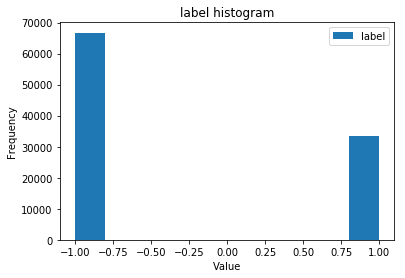

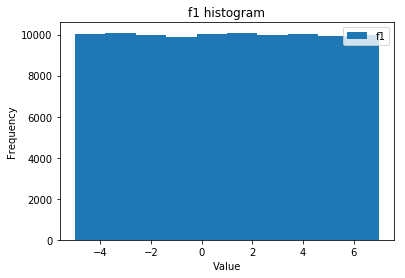

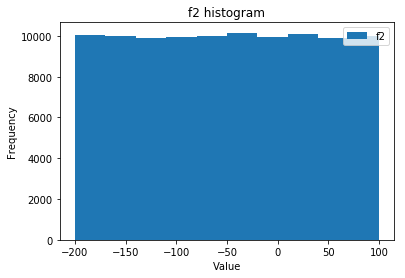

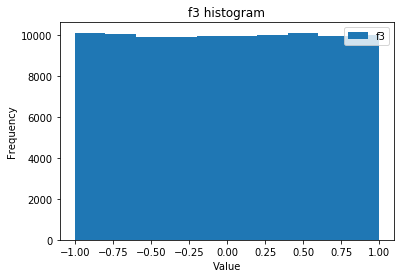

In [4]:
for col in header[1:-1]:
    ax = df_data[[col]].plot.hist(title=col + " histogram")
    ax.set_xlabel("Value")

Text(0.5,1,'c1 hisotgram')

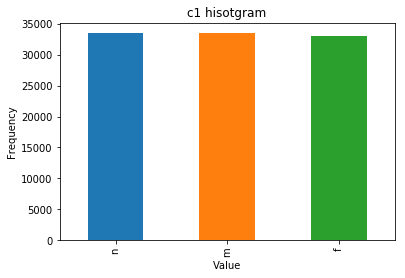

In [5]:
col = "c1"
ax = df_data[col].value_counts().plot(kind='bar')
ax.set_xlabel("Value")
ax.set_ylabel("Frequency")
ax.set_title(col + " hisotgram")

All data looks that are generated from uniform random distribution. 

Label distribution is quite balanced, it is not neccessary to address the problem of imbalance label distribution.

## Correlations

In [6]:
from scipy.stats.stats import pearsonr

header_cor = header[1:-1]
for i_col1, col1 in enumerate(header_cor):
    for i_col2, col2 in enumerate(header_cor):
        if i_col2 < i_col1:
            continue
            
        corr = pearsonr(df_data[col1].values, df_data[col2].values)[0]
        print([col1, col2, corr])

['label', 'label', 1.0]
['label', 'f1', -0.000440789597929063]
['label', 'f2', -0.001474579240498082]
['label', 'f3', 0.10601135408160517]
['f1', 'f1', 1.0]
['f1', 'f2', -0.0012814298800642207]
['f1', 'f3', 0.000938620210926895]
['f2', 'f2', 1.0]
['f2', 'f3', -0.001987876476201404]
['f3', 'f3', 1.0]


Very little correlation between features.

Some correlation between 'label', 'f3' suggests 'f3' will be a feature with the highest feature importace. 'f1', 'f2' has almost no correlation with label. 

If more time I would calculate correlation between 'c1' (would need to transform - one hot encoded)

# Prepare training data

In [7]:
def get_examples(df, col2id):
    ids, xs, ys = [], [], []
    df_values = df_data.values
    
    features_0 = get_features(df_values[0], col2id)
    feature_names = list(sorted(features_0.keys()))
    
    for row in df_values:
        
        id_ = row[col2id["id"]]
        ids.append(id_)
        
        x_dict = get_features(row, col2id)
        x = features_dict2list(x_dict, feature_names)
        xs.append(x)
        
        y = row[col2id["label"]]
        ys.append(y)
    
    return ids, np.array(xs), np.array(ys), feature_names
        
def get_features(row, col2id):
    features = {
        "f1": row[col2id["f1"]],
        "f2": row[col2id["f2"]],
        "f3": row[col2id["f3"]],
        "c1_m": float(row[col2id["c1"]] == "m"),
        "c1_f": float(row[col2id["c1"]] == "f"),
        "c1_n": float(row[col2id["c1"]] == "n"),
    }
    
    return features

def features_dict2list(feature_dict, feature_names):
    return [feature_dict[name] for name in feature_names]


ids, xs, ys, feature_names = get_examples(df_data, col2id)

print("ids:")
pprint(ids[:3])

print("\nFeatures: ")
pprint(feature_names)
pprint(xs[:3])

print("\nLabels:")
pprint(ys[:3])

# To check if correct
df_data[:3]

ids:
[299340, 222579, 152620]

Features: 
['c1_f', 'c1_m', 'c1_n', 'f1', 'f2', 'f3']
array([[ 1.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         2.11413542e+00,  5.32797246e+01,  7.15891235e-01],
       [ 0.00000000e+00,  1.00000000e+00,  0.00000000e+00,
         2.75072936e+00, -6.87238366e+01,  7.83546002e-01],
       [ 0.00000000e+00,  1.00000000e+00,  0.00000000e+00,
        -3.98701774e-01,  3.75175114e+01,  5.77898395e-02]])

Labels:
array([ 1,  1, -1])


,id,label,f1,f2,f3,c1
0,299340,1,2.114135,53.279725,0.715891,f
1,222579,1,2.750729,-68.723837,0.783546,m
2,152620,-1,-0.398702,37.517511,0.057790,m


In [8]:
from sklearn.model_selection import train_test_split
ids_train, ids_dev, x_train, x_dev, y_train, y_dev = train_test_split(ids, xs, ys, test_size=0.2, random_state=42)

print("x_train.shape", x_train.shape)
print("x_dev.shape", x_dev.shape)

print("y_train.shape", y_train.shape)
print("y_dev.shape", y_dev.shape)

x_train.shape (80000, 6)
x_dev.shape (20000, 6)
y_train.shape (80000,)
y_dev.shape (20000,)


# Train the model

In [9]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(max_depth=5, n_estimators=5)

model.fit(x_train, y_train)
y_train_pred = model.predict(x_train)
y_dev_pred = model.predict(x_dev)

# Evaluate

Trainset
f1 = 0.99899

Devset
f1 = 0.99885



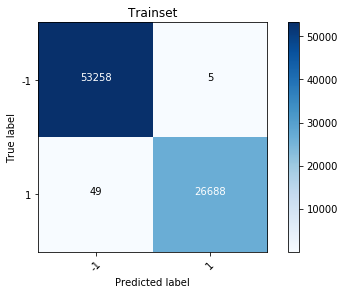

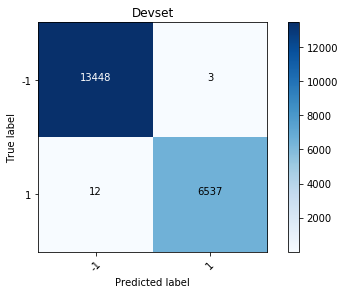

In [10]:
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from tputils import plot_confusion_matrix

def eval_dataset(y_true, y_pred, classes, title):
    print(title)
    
    f1 = f1_score(y_true, y_pred)
    print("f1 = {:.5f}".format(f1))

    conf_matrix = confusion_matrix(y_true, y_pred, labels=classes)
    plot_confusion_matrix(conf_matrix, classes,  normalize=False,title=title)
    
    print()


eval_dataset(y_train, y_train_pred, model.classes_, "Trainset")
eval_dataset(y_dev, y_dev_pred, model.classes_, "Devset")

### Feature importances

In [11]:
list(sorted(zip(feature_names, model.feature_importances_), key=lambda x: x[1], reverse=True))

[('f1', 0.5353720028814247),
 ('c1_n', 0.3629444547825572),
 ('f3', 0.04253853021632673),
 ('c1_f', 0.0407614595054298),
 ('c1_m', 0.017137654282016673),
 ('f2', 0.0012458983322448706)]